<a href="https://colab.research.google.com/github/channeladam/MOOCs/blob/master/SchoolOfAI/DataLit/Week06/DataLit_W6_7_MidTerm_Stock_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Assignment Details

Linear Regression for Price Prediction

Write a Python script that uses linear regression to predict the price of a stock. Pick any company you’d like. 

This is a fun exercise to learn about data preprocessing, python, and using machine learning libraries like sci-kit learn.


In [1]:
!pip install -U seaborn


Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.9.0)


In [0]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import scipy as sp
from scipy.stats import norm

from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score, make_scorer, mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from IPython.core.pylabtools import figsize

import seaborn as sns
sns.set(style='whitegrid')

# Helpers

def map_correlation(df):
  corrmatrix = df.corr(method='pearson')
  mask = np.zeros_like(corrmatrix, dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True
  f, ax = plt.subplots(figsize=(12,12))
  cmap = sns.cubehelix_palette(start=0.6, hue=3.7, rot=0.5, as_cmap=True)
  sns.heatmap(corrmatrix, mask=mask, cmap=cmap, vmin=0.2, square=True, ax=ax)
  return corrmatrix

def map_correlation_coeff(df, cols):
  cm = np.corrcoef(df[cols].values.T)
  sns.set(font_scale=1.5)
  hm = sns.heatmap(cm, cbar=True, annot=True, square=True, 
                   fmt='.2f', annot_kws={'size': 10}, 
                   yticklabels=cols.values, xticklabels=cols.values)
  plt.show()

def prediction_metrics(predictions, actual):
  mae = mean_absolute_error(actual, predictions)
  mse = mean_squared_error(actual, predictions)
  r2 = r2_score(actual, predictions)
  return mae, mse, r2
  
def draw_confusion_matrix(predictions, ground_truth):
  cfm = confusion_matrix(predictions, ground_truth)
  sns.heatmap(cfm, annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')

# Data Acquisition

Using stock price data originally downloaded from https://www.kaggle.com/camnugent/sandp500


In [3]:
!wget -N "https://raw.githubusercontent.com/channeladam/MOOCs/master/SchoolOfAI/DataLit/Week06/Data/NVDA_data.csv"

--2019-03-11 15:47:43--  https://raw.githubusercontent.com/channeladam/MOOCs/master/SchoolOfAI/DataLit/Week06/Data/NVDA_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61715 (60K) [text/plain]
Saving to: ‘NVDA_data.csv’

NVDA_data.csv       100%[===================>]  60.27K  --.-KB/s    in 0.01s   

Last-modified header missing -- time-stamps turned off.
2019-03-11 15:47:43 (3.94 MB/s) - ‘NVDA_data.csv’ saved [61715/61715]



# Exploratory Data Analysis

All the files have the following columns: 
- Date - in format: yy-mm-dd
- Open - price of the stock at market open (this is NYSE data so all in USD)
- High - Highest price reached in the day
- Low Close - Lowest price reached in the day
- Volume - Number of shares traded
- Name - the stock's ticker name


In [0]:
data = pd.read_csv("NVDA_data.csv")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
date      1259 non-null object
open      1259 non-null float64
high      1259 non-null float64
low       1259 non-null float64
close     1259 non-null float64
volume    1259 non-null int64
Name      1259 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 68.9+ KB


In [6]:
data.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,12.3700,12.4699,12.2900,12.3700,7677336,NVDA
1,2013-02-11,12.4700,12.6350,12.3500,12.5100,10207599,NVDA
2,2013-02-12,12.3950,12.5650,12.3800,12.4300,6945065,NVDA
3,2013-02-13,12.4400,12.6650,12.3300,12.3700,21322573,NVDA
4,2013-02-14,12.2000,12.7400,12.0500,12.7300,22049335,NVDA


Open, high, low, close and volume are continuous.

## Data Cleansing

In [0]:
# We're only looking at one stock, so we can drop the name
data.drop('Name', axis=1, inplace=True)

In [8]:
# reconfirm the non-null status of columns from info()
data.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [0]:
# let's get a date datatype
data['date'] = pd.to_datetime(data['date'], yearfirst=True)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 6 columns):
date      1259 non-null datetime64[ns]
open      1259 non-null float64
high      1259 non-null float64
low       1259 non-null float64
close     1259 non-null float64
volume    1259 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 59.1 KB


## Train / Test Data Splitting

In [11]:
data.shape

(1259, 6)

In [0]:
length = data.shape[0]
train_size = int(length * 0.8)

train = data[:train_size]
test = data[train_size:]

In [13]:
train.shape

(1007, 6)

In [14]:
train.iloc[train.shape[0]-1]

date      2017-02-07 00:00:00
open                 118.7000
high                 120.9200
low                  117.9000
close                119.1300
volume               18655567
Name: 1006, dtype: object

In [15]:
test.shape

(252, 6)

In [16]:
test.iloc[0]

date      2017-02-08 00:00:00
open                 118.4000
high                 119.3100
low                  116.3800
close                118.6100
volume               11239487
Name: 1007, dtype: object

train stops at 1006, and test starts at 1007.
Looks good.

## Train Data Analysis

Let's not have any data snooping bias by looking at our test data!

In [17]:
train.describe()

,open,high,low,close,volume
count,1007.0000,1007.0000,1007.0000,1007.0000,1007.0000
mean,29.8772,30.2778,29.5066,29.9346,8819908.1470
std,22.5577,22.9576,22.1849,22.6469,5422961.5812
min,12.0700,12.2900,12.0400,12.1260,1141128.0000
25%,16.1550,16.3075,16.0500,16.2350,5845621.5000
50%,20.3900,20.5500,20.1400,20.3700,7537781.0000
75%,32.3600,32.7600,32.0050,32.4600,9957038.5000
max,119.6000,120.9200,117.9000,119.1300,57394116.0000


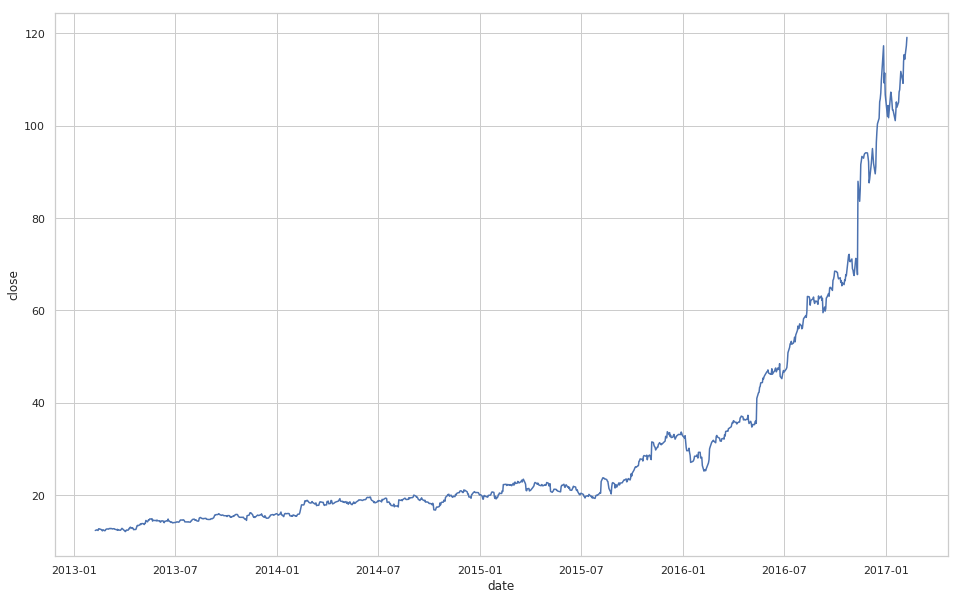

In [18]:
sns.lineplot(x='date', y='close', data=train)

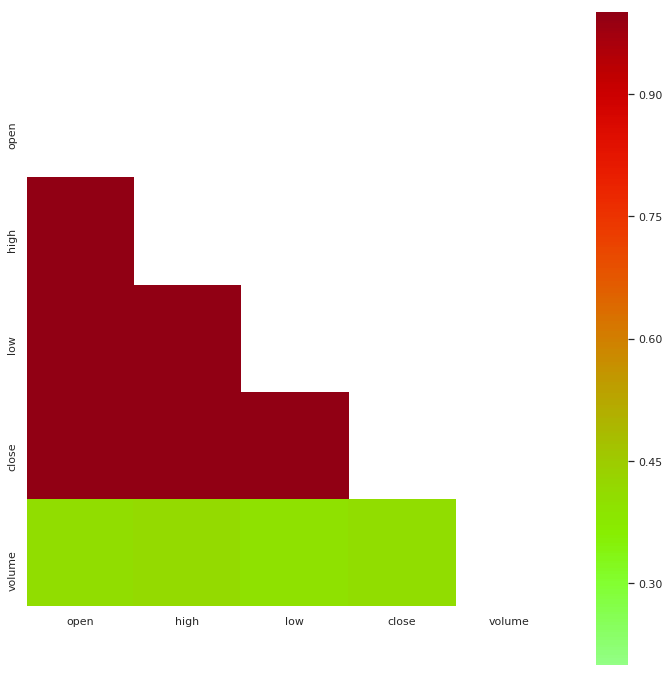

In [19]:
corrmatrix = map_correlation(train)

Close, low and high all correlate strongly... but nothing really does with volume

In [20]:
largest_corrs = corrmatrix.nlargest(10, 'close')['close']
largest_corrs

close    1.0000
high     0.9998
low      0.9997
open     0.9993
volume   0.4067
Name: close, dtype: float64

## Feature Engineering

Volume didn't correlate, so we'll have a look at doing something with that.

In [0]:

# 1 day Momentum
train['1d_momentum'] = train['close'] - train['close'].shift(1)
train['1d_momentum'].fillna(0, inplace=True)

# 5 day Momentum
train['5d_momentum'] = train['close'] - train['close'].shift(4)
train['5d_momentum'].fillna(0, inplace=True)

In [22]:
train.tail(10)

,date,open,high,low,close,volume,1d_momentum,5d_momentum
997,2017-01-25,109.0500,109.3000,106.3346,107.7900,13084499,0.4600,2.6300
998,2017-01-26,107.9000,109.9500,106.7000,109.6500,11469970,1.8600,5.6400
999,2017-01-27,109.9300,111.8900,108.8500,111.7700,11799929,2.1200,6.6800
1000,2017-01-30,110.9200,111.0100,107.9106,110.0200,12400084,-1.7500,2.6900
1001,2017-01-31,108.9500,110.0500,108.2000,109.1800,9068865,-0.8400,1.3900
1002,2017-02-01,110.5800,114.1200,109.8600,113.9500,14750082,4.7700,4.3000
1003,2017-02-02,113.3000,115.7400,112.0600,115.3900,12081040,1.4400,3.6200
1004,2017-02-03,115.4500,115.9000,113.9000,114.3800,9318633,-1.0100,4.3600
1005,2017-02-06,114.0000,117.3261,114.0000,117.3100,12669205,2.9300,8.1300
1006,2017-02-07,118.7000,120.9200,117.9000,119.1300,18655567,1.8200,5.1800


In [23]:
test.head()

,date,open,high,low,close,volume
1007,2017-02-08,118.4000,119.3100,116.3800,118.6100,11239487
1008,2017-02-09,118.8600,119.0600,115.6000,116.3800,21064178
1009,2017-02-10,119.9300,120.7000,112.6000,113.6200,41277341
1010,2017-02-13,113.3900,113.9800,108.2000,108.3800,29518071
1011,2017-02-14,107.9900,110.1500,106.2900,108.7800,21265787


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f47180a7ac8>,
      dtype=object)

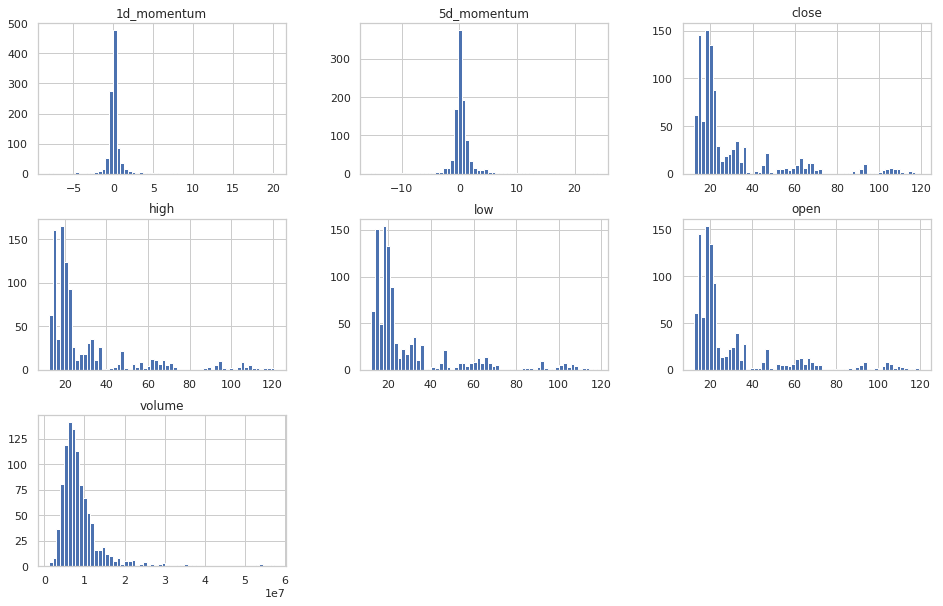

In [24]:
train.hist(bins=60)

Volume is positively skewed and normal distribution looking, so we could take the log of that

In [0]:
train['log_volume'] = np.log(train['volume'])

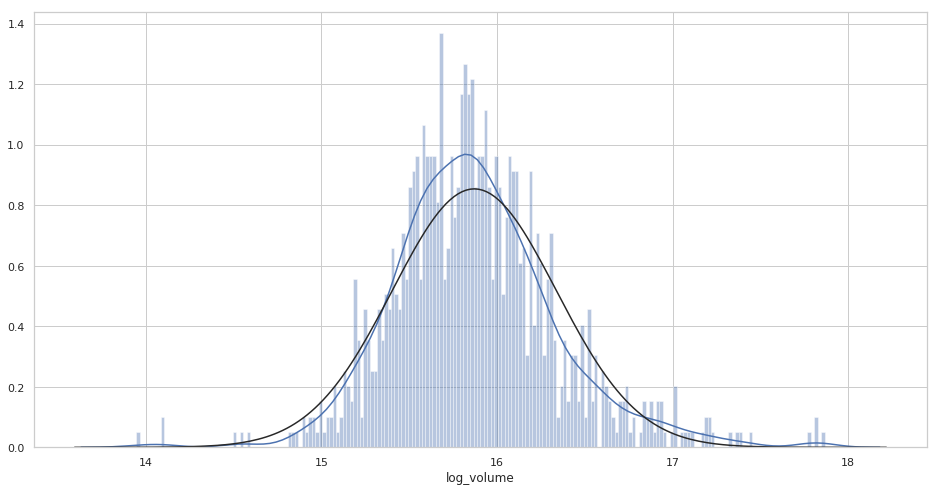

In [26]:
figsize(16,8)
sns.distplot(train['log_volume'], hist=True, bins=int(200), fit=norm)

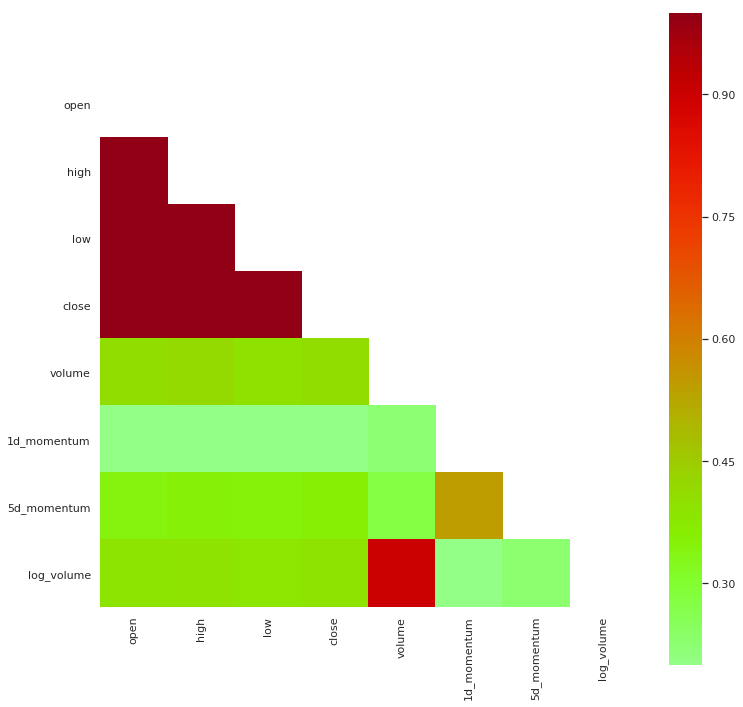

In [27]:
corrmatrix = map_correlation(train)

Okay, there is little correlation for volume, log_volume, or momentum.

In [32]:
largest_corrs = corrmatrix.nlargest(10, 'close')['close']
largest_corrs

close         1.0000
high          0.9998
low           0.9997
open          0.9993
volume        0.4067
log_volume    0.3914
5d_momentum   0.3571
1d_momentum   0.1810
Name: close, dtype: float64

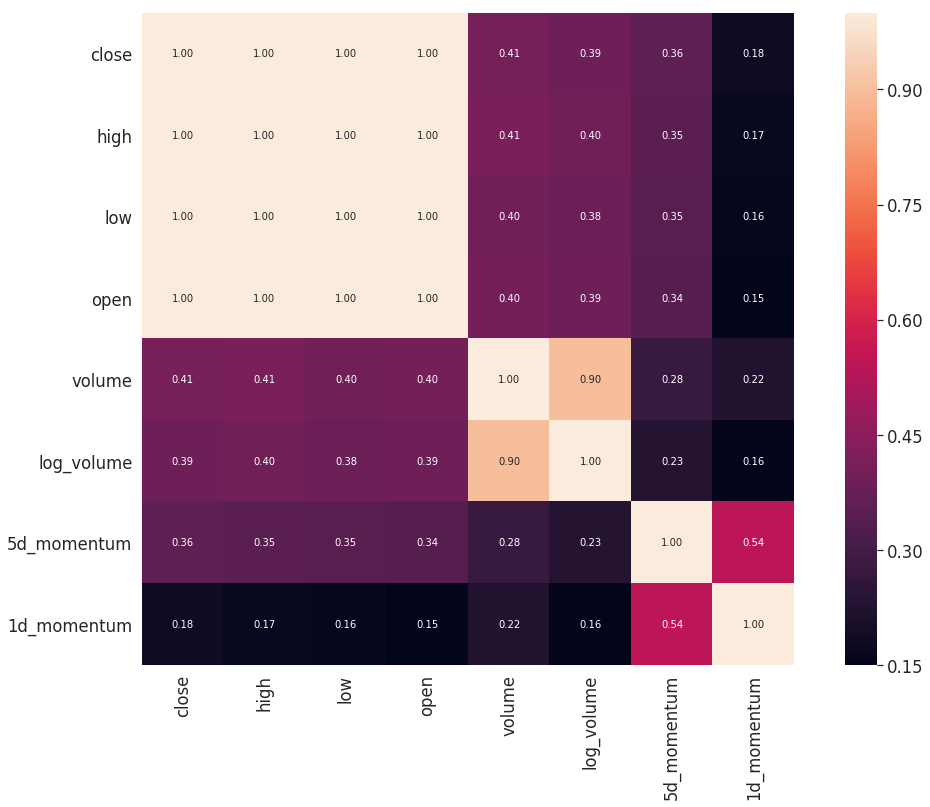

In [33]:
map_correlation_coeff(train, largest_corrs.index)

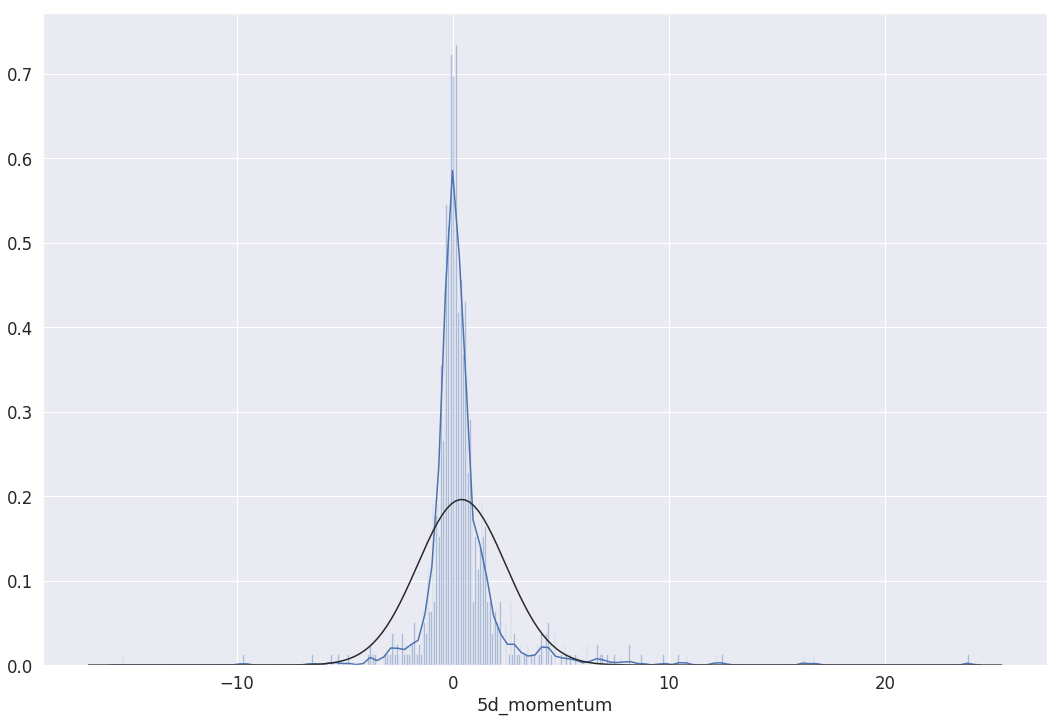

In [34]:
figsize(18,12)
sns.distplot(train['5d_momentum'], bins=500, hist=True, fit=norm)

Interesting how the 5 day momentum appears normal and generally normally distributed

# Regression

So we are going to predict the close price.

No one said we can't use the open, high and low prices for that prediction... in addition to the day.

(otherwise perhaps we might need time series analysis... maybe next week? :) 

## Prepare Data

In [35]:
cols_drop = largest_corrs[ largest_corrs.values < 0.5 ].index.tolist()
cols_drop.append('close')
cols_drop.append('date')
cols_drop

['volume', 'log_volume', '5d_momentum', '1d_momentum', 'close', 'date']

In [59]:
x_train = train.drop(cols_drop, axis=1)
x_train['day'] = x_train.index

y_train = train['close']

(x_train.shape, y_train.shape)

((1007, 4), (1007,))

In [60]:
x_train.tail()

,open,high,low,day
1002,110.5800,114.1200,109.8600,1002
1003,113.3000,115.7400,112.0600,1003
1004,115.4500,115.9000,113.9000,1004
1005,114.0000,117.3261,114.0000,1005
1006,118.7000,120.9200,117.9000,1006


In [61]:
x_test = test.drop(['close','volume','date'], axis=1)
x_test['day'] = x_test.index

y_test = test['close']

(x_test.shape, y_test.shape)

((252, 4), (252,))

In [62]:
x_test.head()

,open,high,low,day
1007,118.4000,119.3100,116.3800,1007
1008,118.8600,119.0600,115.6000,1008
1009,119.9300,120.7000,112.6000,1009
1010,113.3900,113.9800,108.2000,1010
1011,107.9900,110.1500,106.2900,1011


## Linear Regression

In [66]:
from sklearn import linear_model

model = linear_model.LinearRegression()
model.fit(x_train, y_train)

train_pred = model.predict(x_train)

mae, mse, r2 = prediction_metrics(train_pred, y_train)
print("TRAIN: MAE", mae, "MSE", mse, "R2", r2)

test_pred = model.predict(x_test)
mae, mse, r2 = prediction_metrics(test_pred, y_test)
print("TEST: MAE", mae, "MSE", mse, "R2", r2)


TRAIN: MAE 0.16322649888870025 MSE 0.07937496982341673 R2 0.9998450829481347
TEST: MAE 0.9390538517144106 MSE 1.5109647182301138 R2 0.9991360157975119


R2 Looks good... the predictions are close to the regression line...


In [74]:
intercept = model.intercept_
coeffs = dict(zip(x_test.columns.tolist(), model.coef_))

print('intercept:', intercept)
print('coefficients:', coeffs)

intercept: -0.02787657975803981
coefficients: {'open': -0.7321659135333812, 'high': 0.948165173336167, 'low': 0.7840321699805212, 'day': -9.916922059538535e-06}


Compare the actual close price with the predicted close... the blue and red:

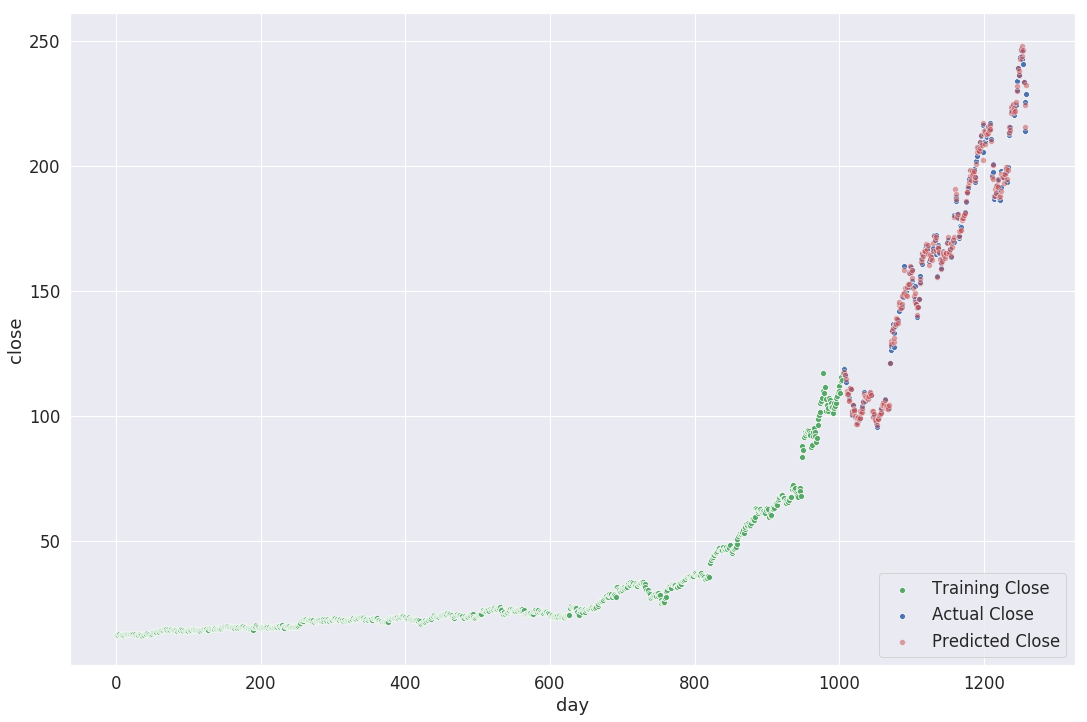

In [68]:
ax = sns.scatterplot(x=x_train.day, y=y_train, color='g', label='Training Close')
plt.xlabel('Day')
plt.ylabel('Close Price')

sns.scatterplot(x=x_test.day, y=y_test, color='b', label='Actual Close')

sns.scatterplot(x=x_test.day, y=test_pred, color='r', label='Predicted Close', alpha=0.5)
#sns.lineplot(x=x_test.day, y=test_pred, color='r', label='Predicted Close', alpha=0.5)

ax.legend(loc='lower right')


And just for comparison, this is what the full original data looked like:

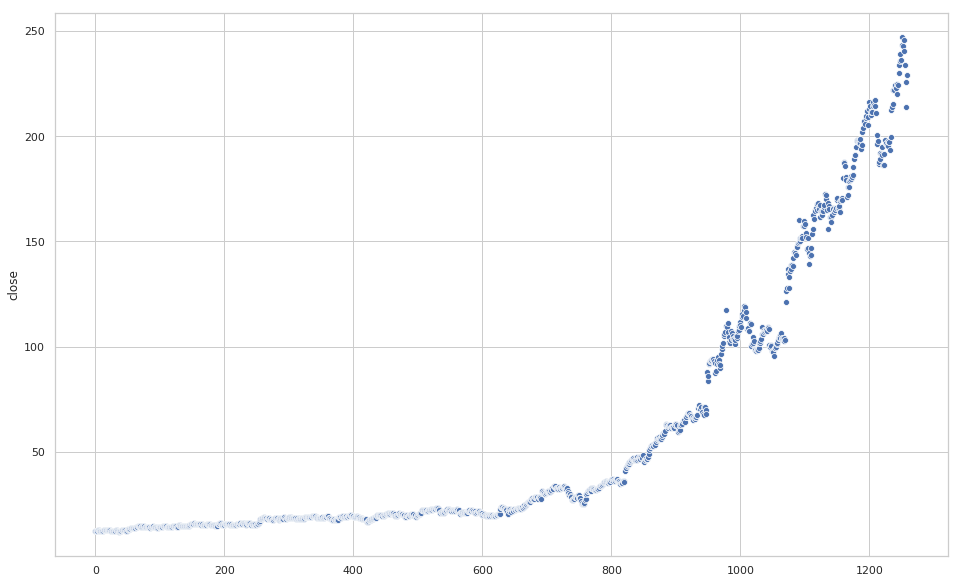

In [101]:
ax = sns.scatterplot(x=data.index, y=data.close, label='Full dataset')
plt.xlabel('Day')
plt.ylabel('Close Price')
ax.legend(loc='lower right')


## Elastic Net Regression

Just out of curiosity... let's try Elastic Net


In [75]:
model = linear_model.ElasticNet(alpha=1, l1_ratio=0.5, normalize=False)
model.fit(x_train, y_train)

train_pred = model.predict(x_train)

mae, mse, r2 = prediction_metrics(train_pred, y_train)
print("TRAIN: MAE", mae, "MSE", mse, "R2", r2)

test_pred = model.predict(x_test)
mae, mse, r2 = prediction_metrics(test_pred, y_test)
print("TEST: MAE", mae, "MSE", mse, "R2", r2)


TRAIN: MAE 0.23952264552189412 MSE 0.2454872727343992 R2 0.999520879634385
TEST: MAE 1.5364384205605148 MSE 4.682930861865522 R2 0.9973222549559361


Doesn't appear to perform as well as the previous linear regressor.

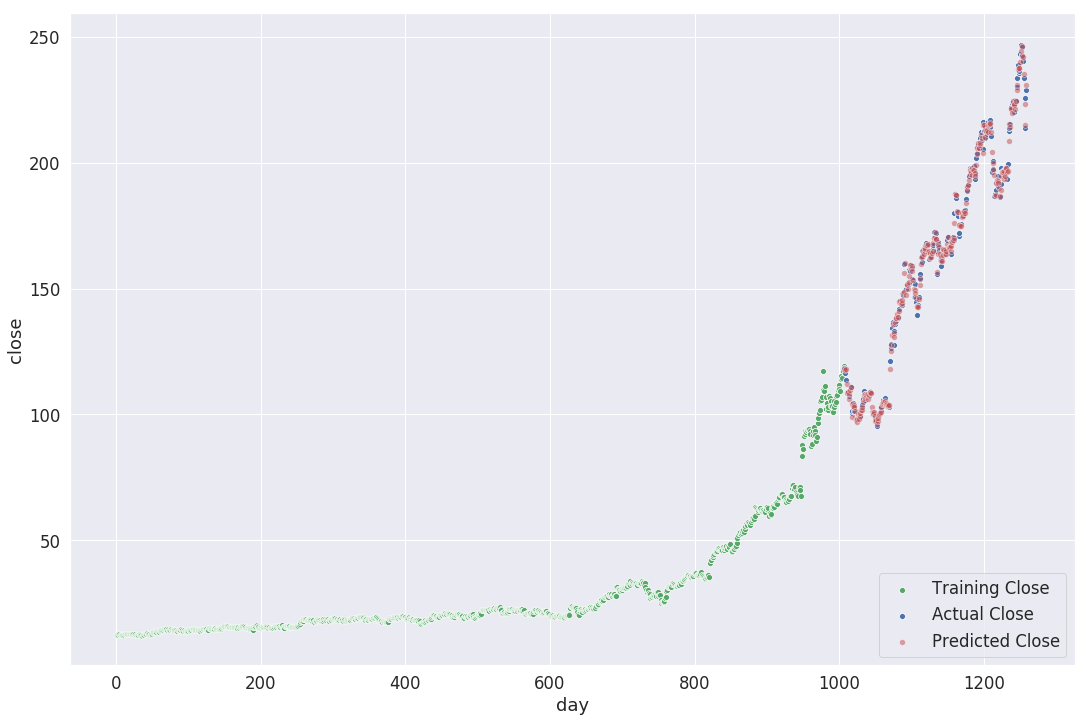

In [76]:
ax = sns.scatterplot(x=x_train.day, y=y_train, color='g', label='Training Close')
plt.xlabel('Day')
plt.ylabel('Close Price')

sns.scatterplot(x=x_test.day, y=y_test, color='b', label='Actual Close')

sns.scatterplot(x=x_test.day, y=test_pred, color='r', label='Predicted Close', alpha=0.5)
#sns.lineplot(x=x_test.day, y=test_pred, color='r', label='Predicted Close', alpha=0.5)

ax.legend(loc='lower right')